In [139]:
import numpy as np
import random
import time
import math
import random
import os
import json
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *

#from to_get_data.generate_database import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety
from model_class.UD_clan import *
from model_class.UD_aleatory_inheritance_clan import *

# General

## Endogamy

In [ ]:
#Not used
def general_charactersitics_data(step, uds, dataset, final = False):
    if final == False:
        for ud in uds.values():
            dataset.append([step, ud.id, ud.age, ud.parentes, ud.varieties])   
        return dataset
    else:
        df = pd.DataFrame(dataset)
        df.columns = ["Step", "ID", "Age", "Parents", "Varieties"]
        return df

In [ ]:
def general_charactersitics_data(step, uds, dataset, clan = True):
    if clan == True:
        for ud in uds.values():
            dataset.append({
                "Step": step,
                "ID": ud.id,
                "Age": ud.age,
                "Parents": ud.parentes,
                "clan": ud.clan,
                "Varieties": [variety.variety_id for variety in ud.varieties]
            })  
        return dataset
    else:
        for ud in uds.values():
            dataset.append({
                "Step": step,
                "ID": ud.id,
                "Age": ud.age,
                "Parents": ud.parentes,
                "Varieties": [variety.variety_id for variety in ud.varieties]
            })
        return dataset

In [34]:
def get_dataset_inheritance(data, keys):
    # Create a DataFrame for each key and store it in a dictionary with a key-related name
    dataframes = {}
    for key in keys:
        data = loaded_data_inherit_endo[key][3]  # 
        # Create DataFrame from the data and assign it to a variable based on the key
        df_name = f"{key}" 
        dataframes[df_name] = pd.DataFrame(data) 
        print(f"{df_name} created.")
    return dataframes

In [40]:
#Functios for the dataset creation
# Function that returns a dictionary in the way: key = step, value = dataset.
def get_datasets_by_step(dataset): # so it has n entries where n is the number of unique steps of the original dataset
    return {step: dataset[dataset['Step'] == step] for step in dataset['Step'].unique()}

In [79]:
# ENDOGAMY. FINAL CONGIFURATION OF EXPERIMENTS
#Parameters endogamy
experiments = 3
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao= 4# Average children per UD
#random.seed(42) # Random seed
t = 400 #steps of the simulation
inheritance = [0,25,50,75,100, 'False']
#inheritance = [0,25,50,75,100]
#inheritance = ['False']
view = 200
time_graf = list(range(0, t+1, view))
data_inherit_endo = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
datasets = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    datasets[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    #Lists to store experiments' data
    data_endo_mean_ud = []
    data_endo_com_level = []
    data_endo_total_varieties = []
    original_media = media
    contador = 0
    for exp in range(1, experiments+1):
        print(f'experimento {exp}')
        net_data = []
        #### Initialization endogamy
        if inherit != 'False':
            UD_endogamy.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation endogamy
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    print("acabo")
                    contador += 1
                    break
                # Cycle: 
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    net_data = general_charactersitics_data(i, uds_copy, net_data, clan = False)
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:   
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                data_endo_mean_ud.append(np.mean(varieties_per_UD))
                data_endo_com_level.append(len(set(total_varieties)))
                data_endo_total_varieties.append(total_varieties)
                #net_data = general_charactersitics_data(i, uds_copy, net_data, final = True)
        #data_inherit_endo[inherit] = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        else:
            UD_endogamy_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation endogamy
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    print("acabo")
                    contador += 1
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, 3)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    net_data = general_charactersitics_data(i, uds_copy, net_data, False)
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_endo_mean_ud.append(np.mean(varieties_per_UD))
                data_endo_com_level.append(len(set(total_varieties)))
                data_endo_total_varieties.append(total_varieties)
                #net_data = general_charactersitics_data(i, uds_copy, net_data, final = True)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 1: #if there are more than 20 alive we use their data
            #print(f'esta si. {alive}')
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
                datasets[inherit].append(net_data)
        data_inherit_endo[inherit] = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
    print(f'{contador}/{experiments}')
    print(contador/experiments)
data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud, datasets]
# Folder
folder_name = 'data_generation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_endo_path = os.path.join(folder_name, 'inherit_data_endo.json')
# By steps
inherit_steps_endo_path = os.path.join(folder_name, 'inherit_steps_data_endo.json')
# Save
with open(inherit_endo_path, 'w') as json_file:
    json.dump(data_inherit_endo, json_file, indent=4)
# Save
with open(inherit_steps_endo_path, 'w') as json_file:
    json.dump(data_steps_inherit_endo, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

Experiments with inheritance 0
experimento 1
experimento 2
experimento 3
0/3
0.0
Experiments with inheritance 25
experimento 1
experimento 2
experimento 3
0/3
0.0
Experiments with inheritance 50
experimento 1
experimento 2
experimento 3
0/3
0.0
Experiments with inheritance 75
experimento 1
experimento 2
experimento 3
0/3
0.0
Experiments with inheritance 100
experimento 1
experimento 2
experimento 3
0/3
0.0
Experiments with inheritance False
experimento 1
experimento 2
experimento 3
0/3
0.0
Data succesfully saved. :D


In [95]:
# Folder
folder_name = 'data_generation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_endo_path = os.path.join(folder_name, 'inherit_data_endo.json')
inherit_steps_endo_path = os.path.join(folder_name, 'inherit_steps_data_endo.json')
# Load
with open(inherit_endo_path, 'r') as json_file:
        loaded_data_inherit_endo = json.load(json_file)
with open(inherit_steps_endo_path, 'r') as json_file:
        loaded_data_inherit_steps_endo = json.load(json_file)
t = 400 #steps of the simulation
view = 200
time_graf = list(range(0, t+1, view))
endogamy_dfs = loaded_data_inherit_steps_endo[3]

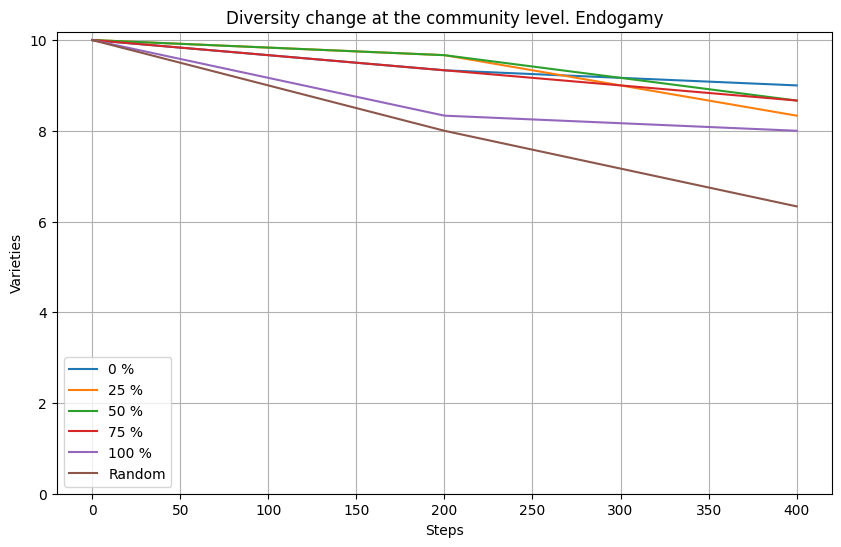

In [75]:
#Define inheritance and palette
inheritance = ['0', '25', '50', '75', '100', 'False']
palette = sns.color_palette("tab10", len(inheritance))

plt.figure(figsize=(10, 6))

for idx, inherit in enumerate(inheritance):
    medias = np.mean(loaded_data_inherit_steps_endo[1][inherit], axis=0)
    desviaciones = np.std(loaded_data_inherit_steps_endo[1][inherit], axis=0)
    
    # Assign colors from tab10 palette
    color = palette[idx]
    
    if inherit == 'False':
        plt.plot(time_graf, medias, label='Random', color=color)
        # plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')
    else:
        plt.plot(time_graf, medias, label=f'{inherit} %', color=color)
        # plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')

plt.xlabel('Steps')
plt.ylabel('Varieties')
plt.ylim(bottom=0)
plt.title('Diversity change at the community level. Endogamy')
plt.legend()
plt.grid(True)
plt.show()

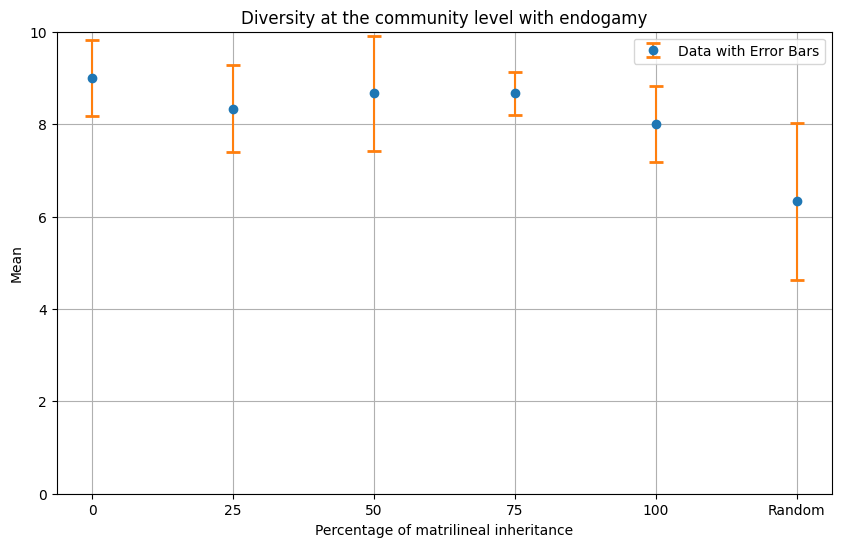

In [76]:
#Define inheritance, calculate mean and std deviation
mean_div_com = []
std_div_com = []
inheritance = ['0', '25', '50', '75', '100', 'False']
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_endo[i][1]))

# Set color palette
palette = sns.color_palette("tab10")
color = palette[0]  # Choose the first color from tab10

# Plot with error bars using a single color
inheritance_possibilities = ['0', '25', '50', '75', '100', 'Random']
plt.figure(figsize=(10, 6))
plt.errorbar(
    inheritance_possibilities,
    mean_div_com,
    yerr=std_div_com,
    fmt='o',
    color=color,
    capsize=5,
    capthick=2,
    ecolor=palette[1],
    label='Data with Error Bars'
)

plt.xlabel('Percentage of matrilineal inheritance')
plt.ylim(0, 10)
plt.ylabel('Mean')
plt.title('Diversity at the community level with endogamy')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
## '0' inherit of the dataset
## n number of the experiment.
test = pd.DataFrame(endogamy_dfs['0'][1])

In [100]:
test

,Step,ID,Age,Parents,Varieties
0,200,365,46,"[308, 332, [411, 419], [278, 259, 258, 269], [...","[6030113, 4030307, 6040208]"
1,200,444,21,"[401, 379, [490, 519, 523, 539], [314, 326, 34...","[4040408, 5060608, 4030307]"
2,200,418,29,"[359, 314, [477, 485, 508, 519], [245, 284, 26...","[5060608, 6050509, 6060712]"
3,200,472,9,"[436, 428, [527, 537, 541, 550, 560, 561], [37...","[5060608, 4040315, 4030307]"
4,200,494,2,"[453, 416, [549, 573], [349, 358, 393, 387], [...","[4040408, 6050509, 5050410]"
...,...,...,...,...,...
268,400,1382,17,"[1278, 1249, None, [1148, 1140, 1191, 1087], [...","[4040408, 5060608, 4030307]"
269,400,1375,18,"[1242, 1221, [1521], [1038, 1064, 1084, 1141],...","[6030113, 4030307, 6040208]"
270,400,1509,3,"[1314, 1270, None, [1087, 1172, 1225, 1114], [...","[5060608, 6050509, 6060712]"
271,400,1379,18,"[1171, 1259, [1522], [1136, 1150, 1008, 1053],...","[4040408, 5060608, 4030307]"


In [106]:
# Pipeline for experiment dataset.
#Add aditional data
test['Num_Varieties_by_house'] = test['Varieties'].apply(lambda x: len(x)) #Column with #of varieties per UD
#Get a dataset for step
unique_steps = test['Step'].unique()
step_datasets = {} #Dict that is going to save one dictionary for each step
for step in unique_steps:
    step_datasets[f"{step}"] = test[test['Step'] == step]

In [116]:
testito = step_datasets['200']

In [140]:
testito

,Step,ID,Age,Parents,Varieties,Num_Varieties_by_house
0,200,365,46,"[308, 332, [411, 419], [278, 259, 258, 269], [...","[6030113, 4030307, 6040208]",3
1,200,444,21,"[401, 379, [490, 519, 523, 539], [314, 326, 34...","[4040408, 5060608, 4030307]",3
2,200,418,29,"[359, 314, [477, 485, 508, 519], [245, 284, 26...","[5060608, 6050509, 6060712]",3
3,200,472,9,"[436, 428, [527, 537, 541, 550, 560, 561], [37...","[5060608, 4040315, 4030307]",3
4,200,494,2,"[453, 416, [549, 573], [349, 358, 393, 387], [...","[4040408, 6050509, 5050410]",3
...,...,...,...,...,...,...
73,200,433,24,"[388, 362, [475, 482, 487, 525, 530, 540], [30...","[5060608, 6050509, 6060712]",3
74,200,461,15,"[386, 414, [504, 510, 522], [332, 340, 314, 32...","[5060608, 6050509, 6060712]",3
75,200,441,22,"[374, 394, None, [307, 329, 338, 289], [425, 4...","[5060608, 6050509, 6060712]",3
76,200,437,23,"[362, 394, [478, 483, 498, 499, 513, 536], [30...","[6030113, 4030307, 6040208]",3


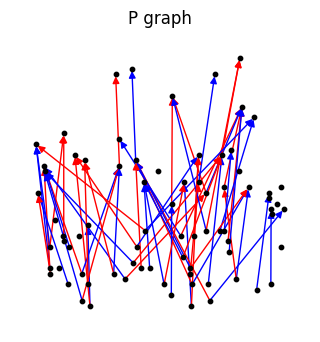

In [213]:
# Step 1: Create a directed graph
G = nx.DiGraph()

# Step 2: Define nodes based on the 'ID' column (each UD becomes a node)
for ud in testito['ID']:  # Assuming 'ID' column represents the UDs
    G.add_node(ud)

# Step 3: Create edges based on the 'Parents' column
edges = []
for _, row in testito.iterrows():
    ud = row["ID"]
    parents = row["Parents"][:2]  # Get the first two parents
    for i, parent in enumerate(parents):
        if parent in testito["ID"].values:  # Check if the parent exists in the dataset
            # Check if it's the first or second parent
            color = 'blue' if i == 0 else 'red'
            edges.append((ud, parent, color))  # Store the edge with its color

# Add edges to the graph with color information
for edge in edges:  # Now we unpack correctly
    G.add_edge(edge[0], edge[1], color=edge[2])  # edge[2] is the color

# Step 4: Adjust the layout based on the age
# Get the age of each node (UD)
age_dict = dict(zip(testito['ID'], testito['Age']))

# Normalize the ages to fit within a desired range (for the y-axis)
min_age = min(age_dict.values())
max_age = max(age_dict.values())

# Map the age to the y-axis position
pos = nx.spring_layout(G, seed=42)  # Initial layout based on spring layout
for node in pos:
    # Normalize the y-coordinate based on age
    age = age_dict[node]
    normalized_y = (age - min_age) / (max_age - min_age)  # Normalize to [0, 1]
    pos[node] = (pos[node][0], normalized_y)  # Set the y position based on normalized age

# Step 5: Visualize the directed graph with adjusted y-axis based on age
# Get the edge colors
edge_colors = [G[u][v]['color'] for u, v in G.edges()]

plt.figure(figsize=(3, 3))
nx.draw(G, pos, with_labels=False, node_size=10, node_color='black', edge_color=edge_colors, width=1)

# Add title and labels
plt.title("P graph")
plt.show()

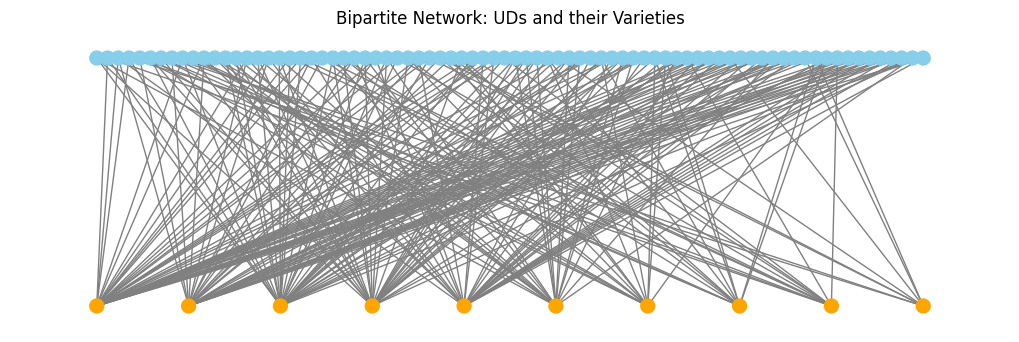

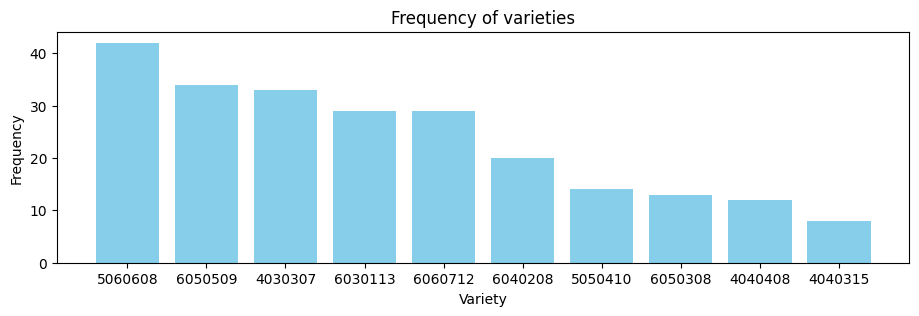

In [215]:
#Networks part
# Bipartite graph of varieties and UDs
B = nx.Graph()
for id_value in testito["ID"]: #UD nodes
    B.add_node(id_value, bipartite=0) 
varieties = set([str(variety) for sublist in testito["Varieties"] for variety in sublist])  # unique varieties
for variety in varieties:  #Variety nodes
    B.add_node(variety, bipartite=1) 

for _, row in testito.iterrows():
    id_value = row["ID"]
    for variety in row["Varieties"]:
        B.add_edge(id_value, str(variety))  # Connect UD with each variety
id_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
variety_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]
variety_nodes_sorted = sorted(variety_nodes, key=lambda node: B.degree(node), reverse=True)
pos = nx.bipartite_layout(B, variety_nodes_sorted)
pos = {node: (y, x) for node, (x, y) in pos.items()}  # Swap x and y to make the layout horizontal
node_colors = ['skyblue' if node in id_nodes else 'orange' for node in B.nodes()]
plt.figure(figsize=(10, 3))
nx.draw(B, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color="gray")
plt.title("Bipartite Network: UDs and their Varieties")
plt.show()
#Data at the level of step
#Diversity: histogram and community level diversity
all_varieties = [str(variety) for sublist in testito['Varieties'] for variety in sublist]
diversity_com_level = len(set(all_varieties))
varieties_counts = Counter(all_varieties)
varieties_counts_sorted = sorted(varieties_counts.items(), key=lambda x: x[1], reverse=True)
varieties, counts = zip(*varieties_counts_sorted)
plt.figure(figsize=(11, 3))
plt.bar(varieties, counts, color='skyblue')
plt.xlabel('Variety')
plt.ylabel('Frequency')
plt.title('Frequency of varieties')
plt.show()

## Dual organization

In [27]:
#Esta es la que sirve. QUe hice? solo guardo los finales que terminan con unidades, los otros no. FALTA APLICAR 
# AL GENERALIZED Y LISTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
#DUAL ORGANIZATION
#Parameters dual_organization
experiments = 100
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
#random.seed(42) # Random seed
t = 1000 #steps of the simulation
view = 50
time_graf = list(range(0, t+1, view))
inheritance = [0,25,50,75,100, 'False']
#inheritance = ['False']
data_inherit_dual = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    data_dual_mean_ud = []
    data_dual_com_level = []
    data_dual_total_varieties = []
    original_media = media
    contador = 0
    for exp in range(1,experiments+1):
        mean_var_ud = []
        var_system = []
        unique_system = []
        print(f'experimento {exp}')
        #### Initialization dual_organization
        ## Clans
        clans = (list(range(1, 2 + 1)) * (iniciais // 2)) # Just 2 clans
        random.shuffle(clans)
        if inherit != 'False':
            UD_dual_organization.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(f' no ano {i} temos a media {media}')
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(f' no ano {i} temos a media {media}')
                if not uds_copy:
                    contador += 1
                    print("acabo")
                    break
                # CYcle
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
#             #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_dual_mean_ud.append(np.mean(varieties_per_UD))
                data_dual_com_level.append(len(set(total_varieties)))
                data_dual_total_varieties.append(total_varieties)
        #data_inherit_dual[inherit] = [data_dual_mean_ud, data_dual_com_level, data_dual_total_varieties]
        else:
            UD_dual_organization_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    contador += 1
                    print("acabo")
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, True, 3, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total))) 
#             #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
#             #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:    
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_dual_mean_ud.append(np.mean(varieties_per_UD))
                data_dual_com_level.append(len(set(total_varieties)))
                data_dual_total_varieties.append(total_varieties)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 20: #if there are more than 20 alive we use their data
            #print(f'esta si. {alive}')
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
#                 data_dual_mean_ud.append(np.mean(varieties_per_UD))
#                 data_dual_com_level.append(len(set(total_varieties)))
#                 data_dual_total_varieties.append(total_varieties)
                data_inherit_dual[inherit] = [data_dual_mean_ud, data_dual_com_level, data_dual_total_varieties]
    print(f'{contador}/{experiments}')
    print(contador/experiments)
data_steps_inherit_dual = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_dual_path = os.path.join(folder_name, 'inherit_data_dual.json')
# By steps
inherit_steps_dual_path = os.path.join(folder_name, 'inherit_steps_data_dual.json')
# Save
with open(inherit_dual_path, 'w') as json_file:
    json.dump(data_inherit_dual, json_file, indent=4)
with open(inherit_steps_dual_path, 'w') as json_file:
    json.dump(data_steps_inherit_dual, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

Experiments with inheritance 0
experimento 1
experimento 2
experimento 3
acabo
experimento 4
experimento 5
experimento 6
experimento 7
experimento 8
acabo
experimento 9
experimento 10
experimento 11
acabo
experimento 12
experimento 13
acabo
experimento 14
experimento 15
experimento 16
experimento 17
experimento 18
experimento 19
experimento 20
acabo
experimento 21
experimento 22
acabo
experimento 23
experimento 24
experimento 25
experimento 26
experimento 27
experimento 28
experimento 29
acabo
experimento 30
experimento 31
acabo
experimento 32
experimento 33
experimento 34
experimento 35
experimento 36
experimento 37
experimento 38
experimento 39
experimento 40
experimento 41
experimento 42
acabo
experimento 43
experimento 44
experimento 45
experimento 46
experimento 47
experimento 48
experimento 49
experimento 50
acabo
experimento 51
experimento 52
experimento 53
experimento 54
experimento 55
experimento 56
experimento 57
experimento 58
experimento 59
experimento 60
experimento 61
exp

19/100
0.19
Experiments with inheritance False
experimento 1
experimento 2
experimento 3
acabo
experimento 4
experimento 5
experimento 6
experimento 7
experimento 8
experimento 9
acabo
experimento 10
experimento 11
acabo
experimento 12
experimento 13
acabo
experimento 14
acabo
experimento 15
experimento 16
experimento 17
acabo
experimento 18
experimento 19
acabo
experimento 20
experimento 21
experimento 22
acabo
experimento 23
experimento 24
experimento 25
experimento 26
experimento 27
experimento 28
experimento 29
experimento 30
experimento 31
experimento 32
experimento 33
experimento 34
experimento 35
experimento 36
experimento 37
experimento 38
experimento 39
acabo
experimento 40
experimento 41
experimento 42
experimento 43
experimento 44
experimento 45
experimento 46
experimento 47
experimento 48
acabo
experimento 49
experimento 50
experimento 51
experimento 52
experimento 53
experimento 54
experimento 55
acabo
experimento 56
experimento 57
experimento 58
experimento 59
experimento

c:\users\jsolm\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\jsolm\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


acabo
experimento 75
acabo
experimento 76
acabo
experimento 77
experimento 78
acabo
experimento 79
experimento 80
acabo
experimento 81
experimento 82
experimento 83
experimento 84
experimento 85
acabo
experimento 86
experimento 87
experimento 88
experimento 89
experimento 90
experimento 91
acabo
experimento 92
experimento 93
experimento 94
experimento 95
acabo
experimento 96
experimento 97
acabo
experimento 98
experimento 99
experimento 100
21/100
0.21
Data succesfully saved. :D


In [9]:
t = 1000 #steps of the simulation
view = 50
time_graf = list(range(0, t+1, view))
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_dual_path = os.path.join(folder_name, 'inherit_data_dual.json')
inherit_steps_dual_path = os.path.join(folder_name, 'inherit_steps_data_dual.json')
# Load
with open(inherit_dual_path, 'r') as json_file:
        loaded_data_inherit_dual = json.load(json_file)
with open(inherit_steps_dual_path, 'r') as json_file:
        loaded_data_inherit_steps_dual = json.load(json_file)

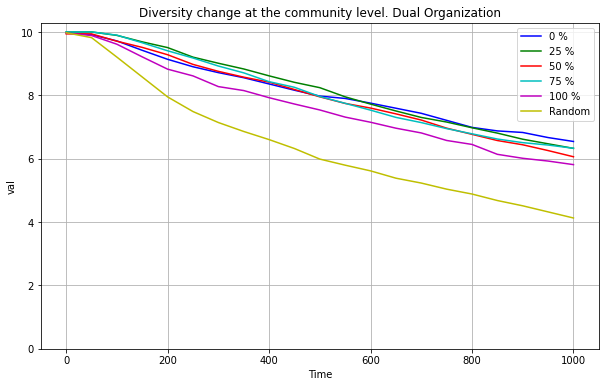

In [35]:
#By steps graphs
inheritance = ['0','25','50','75','100', 'False']
#inheritance = ['False']

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 6))

for idx, inherit in enumerate(inheritance):
    #print(inherit)
    medias = np.mean(loaded_data_inherit_steps_dual[1][inherit], axis=0)
    desviaciones = np.std(loaded_data_inherit_steps_dual[1][inherit], axis=0)
    
    # Asigna un color diferente a cada línea
    color = colors[idx % len(colors)]
    
    if inherit == 'False':
        plt.plot(time_graf, medias, label=f'Random', color=color)
        #plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')
    else:
        plt.plot(time_graf, medias, label=f'{inherit} %', color=color)
        #plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')

plt.xlabel('Time')
plt.ylabel('val')
plt.ylim(bottom=0)
plt.title('Diversity change at the community level. Dual Organization')
plt.legend()
plt.grid(True)
plt.show()

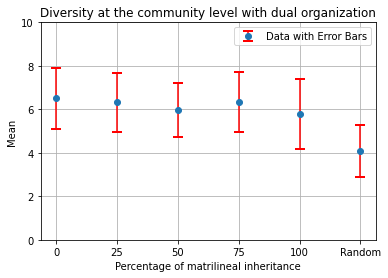

In [31]:
## Data and plot from loaded data
mean_div_com = []
std_div_com = []
inheritance = ['0','25','50','75','100', 'False']
#inheritance = ['False']
#inheritance = [100,90,80,70,60,50, False]
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_dual[i][1]))
#Plot
inheritance_possibilities = ['0','25','50','75','100', 'Random']
#inheritance_possibilities = ['Random']
plt.errorbar(inheritance_possibilities, mean_div_com, yerr=std_div_com, fmt='o', capsize=5, capthick=2, ecolor='red', label='Data with Error Bars')
plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Mean')
plt.ylim(0,10)
plt.title('Diversity at the community level with dual organization')
plt.legend()
plt.grid(True)
plt.show()

## Generalized

In [2]:
#UD_generalized
#Parameters Generalized_exchange
experiments = 200
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
#random.seed(42) # Random seed
t = 1000 #steps of the simulation
inheritance = [0,25,50,75,100, 'False']
#inheritance = [0,25,50,75,100]
#inheritance = ['False']
view = 50
time_graf = list(range(0, t+1, view))
data_inherit_generalized = {}
data_step_mean_var_ud = {}
data_step_var_system = {}
data_step_unique_system = {}
for inherit in inheritance:
    data_step_mean_var_ud[inherit] = []
    data_step_var_system[inherit] = []
    data_step_unique_system[inherit] = []
    media = mediao
    print(f"Experiments with inheritance {inherit}")
    data_generalized_mean_ud = []
    data_generalized_com_level = []
    data_generalized_total_varieties = []
    original_media = media
    contador = 0
    for exp in range (1, experiments+1):
        mean_var_ud = []
        var_system = []
        unique_system = []
        print(f'experimento {exp}')
        #### Initialization generalized_exchange
        ## Clans
        clans = (list(range(1, 4)) * (iniciais // 3 + 1))[:iniciais] # Just 3 clans
        random.shuffle(clans)
        if inherit != 'False':
            UD_generalized.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation generalized
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): 
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    contador += 1
                    print("acabo")
                    break
                # Cycle
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, inherit, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
            #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_generalized_mean_ud.append(np.mean(varieties_per_UD))
                data_generalized_com_level.append(len(set(total_varieties)))
                data_generalized_total_varieties.append(total_varieties)
        else:
            UD_generalized_al_inh.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized_al_inh.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized_al_inh.uds.values():
                    random_samples = random.sample(initial_varieties, 3)
                    for sample in random_samples:
                        ud.varieties.append(sample)
            mean_var_ud = []
            var_system = []
            unique_system = []
            var_ud = []
            var_total = []
            for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                var_ud.append(len(ud.varieties))
                for variety in ud.varieties:
                    var_total.append(variety.variety_id)
            mean_var_ud.append(np.mean(var_ud))
            var_system.append(len(var_total))
            unique_system.append(len(set(var_total)))
            #### Simulation
            for i in range (1, (t+1)):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    contador += 1
                    print("acabo")
                    break
                # Cycle: 
                varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, varieties_list, True, 3, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                if i%view == 0:
                    var_ud = []
                    var_total = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        var_ud.append(len(ud.varieties))
                        for variety in ud.varieties:
                            var_total.append(variety.variety_id)
                    mean_var_ud.append(np.mean(var_ud))
                    var_system.append(len(var_total))
                    unique_system.append(len(set(var_total)))
            #print(len([ud for id, ud in uds_copy.items() if ud.activa]))
            #Get the distribution, community diversity and mean by UD
            if (len([ud for id, ud in uds_copy.items() if ud.activa])) >= 1:
                total_varieties = []
                varieties_per_UD = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    varieties_per_UD.append(len(ud.varieties))
                    for variety in ud.varieties:
                        total_varieties.append(variety.variety_id)
                #mean_ud = np.mean(varieties_per_UD)
                #diversity_comm_level = len(set(total_varieties))
                data_generalized_mean_ud.append(np.mean(varieties_per_UD))
                data_generalized_com_level.append(len(set(total_varieties)))
                data_generalized_total_varieties.append(total_varieties)
        alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
        if alive >= 20: #if there are more than 20 alive we use their data
            if len(mean_var_ud) == len(time_graf):        
                data_step_var_system[inherit].append(var_system)
                data_step_unique_system[inherit].append(unique_system)
                data_step_mean_var_ud[inherit].append(mean_var_ud)
        data_inherit_generalized[inherit] = [data_generalized_mean_ud, data_generalized_com_level, data_generalized_total_varieties]
    print(f'{contador}/{experiments}')
    print(contador/experiments)
data_steps_inherit_generalized = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud] 
    
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_generalized_path = os.path.join(folder_name, 'inherit_data_generalized.json')
# By steps
inherit_steps_generalized_path = os.path.join(folder_name, 'inherit_steps_data_generalized.json')
# Save
with open(inherit_generalized_path, 'w') as json_file:
    json.dump(data_inherit_generalized, json_file, indent=4)
with open(inherit_steps_generalized_path, 'w') as json_file:
    json.dump(data_steps_inherit_generalized, json_file, indent=4)
# Confirmation message
print("Data succesfully saved. :D")

Experiments with inheritance 0
experimento 1
acabo
experimento 2
acabo
experimento 3
experimento 4
acabo
experimento 5
experimento 6
experimento 7
acabo
experimento 8
acabo
experimento 9
experimento 10
acabo
experimento 11
experimento 12
acabo
experimento 13
experimento 14
acabo
experimento 15
acabo
experimento 16
experimento 17
acabo
experimento 18
acabo
experimento 19
acabo
experimento 20
experimento 21
experimento 22
acabo
experimento 23
acabo
experimento 24
acabo
experimento 25
acabo
experimento 26
acabo
experimento 27
experimento 28
experimento 29
acabo
experimento 30
experimento 31
experimento 32
experimento 33
experimento 34
acabo
experimento 35
acabo
experimento 36
acabo
experimento 37
experimento 38
acabo
experimento 39
experimento 40
acabo
experimento 41
acabo
experimento 42
acabo
experimento 43
experimento 44
acabo
experimento 45
acabo
experimento 46
experimento 47
acabo
experimento 48
experimento 49


c:\users\jsolm\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\jsolm\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


acabo
experimento 50
acabo
experimento 51
experimento 52
experimento 53
acabo
experimento 54
acabo
experimento 55
acabo
experimento 56
acabo
experimento 57
experimento 58
acabo
experimento 59
experimento 60
acabo
experimento 61
acabo
experimento 62
experimento 63
experimento 64
acabo
experimento 65
experimento 66
experimento 67
acabo
experimento 68
acabo
experimento 69
experimento 70
acabo
experimento 71
acabo
experimento 72
experimento 73
experimento 74
acabo
experimento 75
acabo
experimento 76
experimento 77
acabo
experimento 78
experimento 79
experimento 80
acabo
experimento 81
experimento 82
acabo
experimento 83
acabo
experimento 84
acabo
experimento 85
experimento 86
acabo
experimento 87
acabo
experimento 88
experimento 89
experimento 90
acabo
experimento 91
acabo
experimento 92
experimento 93
acabo
experimento 94
acabo
experimento 95
acabo
experimento 96
experimento 97
acabo
experimento 98
experimento 99
experimento 100
experimento 101
acabo
experimento 102
experimento 103
acabo


experimento 90
experimento 91
acabo
experimento 92
experimento 93
experimento 94
acabo
experimento 95
experimento 96
acabo
experimento 97
experimento 98
experimento 99
acabo
experimento 100
experimento 101
acabo
experimento 102
experimento 103
experimento 104
acabo
experimento 105
experimento 106
acabo
experimento 107
experimento 108
acabo
experimento 109
acabo
experimento 110
acabo
experimento 111
experimento 112
acabo
experimento 113
experimento 114
experimento 115
acabo
experimento 116
acabo
experimento 117
acabo
experimento 118
acabo
experimento 119
experimento 120
acabo
experimento 121
experimento 122
experimento 123
acabo
experimento 124
experimento 125
acabo
experimento 126
experimento 127
acabo
experimento 128
acabo
experimento 129
acabo
experimento 130
experimento 131
acabo
experimento 132
acabo
experimento 133
experimento 134
experimento 135
acabo
experimento 136
acabo
experimento 137
acabo
experimento 138
experimento 139
experimento 140
experimento 141
experimento 142
acabo


acabo
experimento 130
acabo
experimento 131
acabo
experimento 132
acabo
experimento 133
experimento 134
experimento 135
experimento 136
acabo
experimento 137
acabo
experimento 138
experimento 139
acabo
experimento 140
experimento 141
acabo
experimento 142
acabo
experimento 143
acabo
experimento 144
acabo
experimento 145
acabo
experimento 146
acabo
experimento 147
acabo
experimento 148
experimento 149
experimento 150
acabo
experimento 151
experimento 152
acabo
experimento 153
experimento 154
acabo
experimento 155
acabo
experimento 156
acabo
experimento 157
experimento 158
experimento 159
experimento 160
acabo
experimento 161
acabo
experimento 162
experimento 163
acabo
experimento 164
experimento 165
experimento 166
acabo
experimento 167
acabo
experimento 168
experimento 169
experimento 170
acabo
experimento 171
acabo
experimento 172
experimento 173
experimento 174
experimento 175
acabo
experimento 176
acabo
experimento 177
experimento 178
acabo
experimento 179
acabo
experimento 180
expe

In [8]:
t=1000
view = 50
time_graf = list(range(0, t+1, view))
# Folder
folder_name = 'results_inheritance_aleatory_clan'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Inherit data
inherit_restricted_path = os.path.join(folder_name, 'inherit_data_generalized.json')
inherit_steps_restricted_path = os.path.join(folder_name, 'inherit_steps_data_generalized.json')
# Load
with open(inherit_restricted_path, 'r') as json_file:
        loaded_data_inherit_restricted = json.load(json_file)
with open(inherit_steps_restricted_path, 'r') as json_file:
        loaded_data_inherit_steps_restricted = json.load(json_file)

In [7]:
loaded_data_inherit_steps_restricted[1][inherit]

[[10, 10, 10, 10, 10, 9, 9, 9, 7, 7, 7, 7, 8, 6, 6, 8, 8, 8, 7, 7, 7, 7, 7, 7],
 [9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [10, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 8, 7, 8, 8, 8, 8, 8, 7, 7, 4, 7, 7, 7],
 [10, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5],
 [10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9],
 [10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8],
 [10, 7, 7, 7, 7, 6, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  9,
  9,
  9,
  9,
  9,
  9,
  9],
 [10,
  10,
  10,
  10,
  9,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  9,
  9,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,


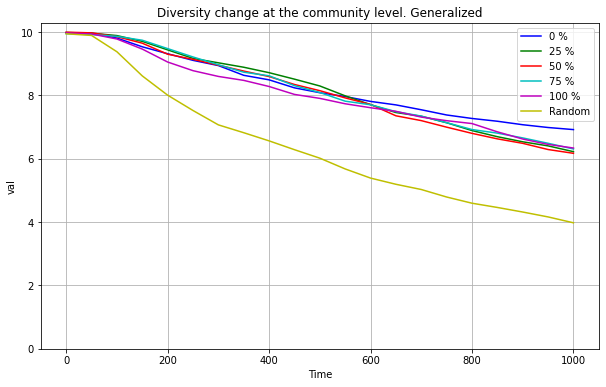

In [9]:
#By steps graphs
inheritance = ['0','25','50','75','100', 'False']
# inheritance = ['False']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 6))

for idx, inherit in enumerate(inheritance):
    #print(inherit)
    medias = np.mean(loaded_data_inherit_steps_restricted[1][inherit], axis=0)
    desviaciones = np.std(loaded_data_inherit_steps_restricted[1][inherit], axis=0)
    
    # Asigna un color diferente a cada línea
    color = colors[idx % len(colors)]
    
    if inherit == 'False':
        plt.plot(time_graf, medias, label=f'Random', color=color)
        #plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')
    else:
        plt.plot(time_graf, medias, label=f'{inherit} %', color=color)
        #plt.fill_between(time_graf, medias - desviaciones, medias + desviaciones, color=color, alpha=0.2, label=f'Std {inherit}')


plt.xlabel('Time')
plt.ylabel('val')
plt.ylim(bottom=0)
plt.title('Diversity change at the community level. Generalized')
plt.legend()
plt.grid(True)
plt.show()

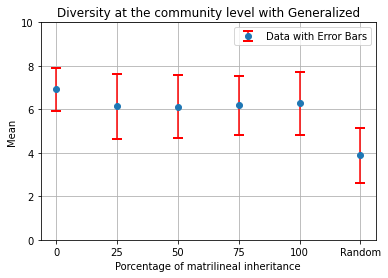

In [10]:
## Data and plot from loaded data
mean_div_com = []
std_div_com = []
inheritance = ['0','25','50','75','100', 'False']
# inheritance = ['False']
#inheritance = [100,90,80,70,60,50, False]
for i in inheritance:
    mean_div_com.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com.append(np.std(loaded_data_inherit_restricted[i][1]))
#Plot
inheritance_possibilities = ['0','25','50','75','100', 'Random']
# inheritance_possibilities = ['Random']
plt.errorbar(inheritance_possibilities, mean_div_com, yerr=std_div_com, fmt='o', capsize=5, capthick=2, ecolor='red', label='Data with Error Bars')
plt.xlabel('Porcentage of matrilineal inheritance')
plt.ylabel('Mean')
plt.ylim(0,10)
plt.title('Diversity at the community level with Generalized')
plt.legend()
plt.grid(True)
plt.show()

# To visualize all of them at the same time

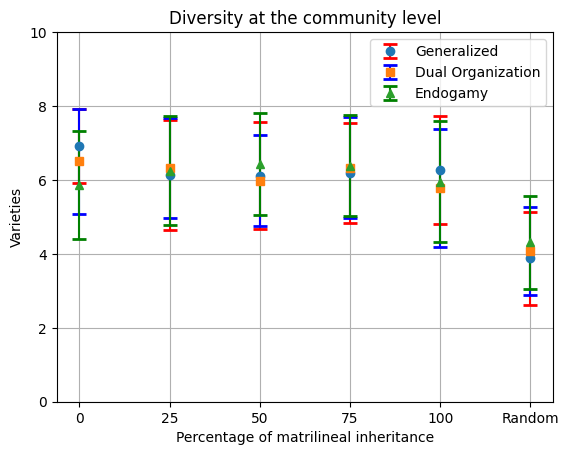

In [10]:
# Lists
mean_div_com_restricted = []
std_div_com_restricted = []
mean_div_com_dual = []
std_div_com_dual = []
mean_div_com_endo = []
std_div_com_endo = []
inheritance = ['0','25','50','75','100', 'False']
# Mean and std
for i in inheritance:
    mean_div_com_restricted.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com_restricted.append(np.std(loaded_data_inherit_restricted[i][1]))
    mean_div_com_dual.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com_dual.append(np.std(loaded_data_inherit_dual[i][1]))
    mean_div_com_endo.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com_endo.append(np.std(loaded_data_inherit_endo[i][1]))

inheritance_possibilities = ['0','25','50','75','100', 'Random']
#Plot
plt.errorbar(inheritance_possibilities, mean_div_com_restricted, yerr=std_div_com_restricted, fmt='o', capsize=5, capthick=2, ecolor='red', label='Generalized')
plt.errorbar(inheritance_possibilities, mean_div_com_dual, yerr=std_div_com_dual, fmt='s', capsize=5, capthick=2, ecolor='blue', label='Dual Organization')
plt.errorbar(inheritance_possibilities, mean_div_com_endo, yerr=std_div_com_endo, fmt='^', capsize=5, capthick=2, ecolor='green', label='Endogamy')
plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Varieties')
plt.ylim(0,10)
plt.title('Diversity at the community level')
plt.legend()
plt.grid(True)
plt.show()

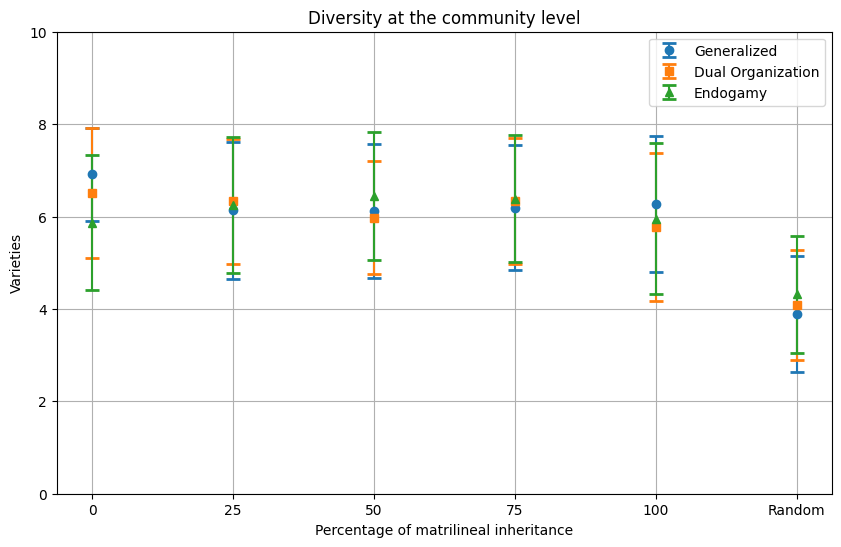

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define inheritance, calculate means and standard deviations
mean_div_com_restricted = []
std_div_com_restricted = []
mean_div_com_dual = []
std_div_com_dual = []
mean_div_com_endo = []
std_div_com_endo = []
inheritance = ['0', '25', '50', '75', '100', 'False']

# Calculate mean and std deviation
for i in inheritance:
    mean_div_com_restricted.append(np.mean(loaded_data_inherit_restricted[i][1]))
    std_div_com_restricted.append(np.std(loaded_data_inherit_restricted[i][1]))
    mean_div_com_dual.append(np.mean(loaded_data_inherit_dual[i][1]))
    std_div_com_dual.append(np.std(loaded_data_inherit_dual[i][1]))
    mean_div_com_endo.append(np.mean(loaded_data_inherit_endo[i][1]))
    std_div_com_endo.append(np.std(loaded_data_inherit_endo[i][1]))

inheritance_possibilities = ['0', '25', '50', '75', '100', 'Random']

# Set color palette
palette = sns.color_palette("tab10")

# Plot with error bars using colors from tab10
plt.figure(figsize=(10, 6))
plt.errorbar(inheritance_possibilities, mean_div_com_restricted, yerr=std_div_com_restricted,
             fmt='o', capsize=5, capthick=2, color=palette[0], ecolor=palette[0], label='Generalized')
plt.errorbar(inheritance_possibilities, mean_div_com_dual, yerr=std_div_com_dual,
             fmt='s', capsize=5, capthick=2, color=palette[1], ecolor=palette[1], label='Dual Organization')
plt.errorbar(inheritance_possibilities, mean_div_com_endo, yerr=std_div_com_endo,
             fmt='^', capsize=5, capthick=2, color=palette[2], ecolor=palette[2], label='Endogamy')

plt.xlabel('Percentage of matrilineal inheritance')
plt.ylabel('Varieties')
plt.ylim(0, 10)
plt.title('Diversity at the community level')
plt.legend()
plt.grid(True)
plt.show()